In [7]:
import numpy as np
import pandas as pd
import os
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import (
    DateRange,
    Dimension,
    Metric,
    RunReportRequest,
    OrderBy
)

In [ ]:
property_id = ""
json_path_cred = ""
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = json_path_cred

client = BetaAnalyticsDataClient()

In [10]:
## Format Report - run_report method
def format_report(request):
    response = client.run_report(request)
    
    # Row index
    row_index_names = [header.name for header in response.dimension_headers]
    row_header = []
    for i in range(len(row_index_names)):
        row_header.append([row.dimension_values[i].value for row in response.rows])

    row_index_named = pd.MultiIndex.from_arrays(np.array(row_header), names = np.array(row_index_names))
    # Row flat data
    metric_names = [header.name for header in response.metric_headers]
    data_values = []
    for i in range(len(metric_names)):
        data_values.append([row.metric_values[i].value for row in response.rows])

    output = pd.DataFrame(data = np.transpose(np.array(data_values, dtype = 'f')), 
                          index = row_index_named, columns = metric_names)
    return output

In [11]:
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month"), 
                    Dimension(name="sessionMedium")],
        metrics=[Metric(name="averageSessionDuration"), 
                 Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}),
                    OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
        date_ranges=[DateRange(start_date="2022-06-01", end_date="today")],
    )

request

property: "properties/393868269"
dimensions {
  name: "month"
}
dimensions {
  name: "sessionMedium"
}
metrics {
  name: "averageSessionDuration"
}
metrics {
  name: "activeUsers"
}
date_ranges {
  start_date: "2022-06-01"
  end_date: "today"
}
order_bys {
  dimension {
    dimension_name: "month"
  }
}
order_bys {
  dimension {
    dimension_name: "sessionMedium"
  }
}

In [12]:
format_report(request)

averageSessionDuration  activeUsers
month sessionMedium                                     
01    (none)                      59.116703        338.0
      (not set)                    0.005763          3.0
      cpc                          3.368161          2.0
      organic                    191.002045        465.0
      paid                         0.000000          7.0
...                                     ...          ...
12    (not set)                    2.804830          9.0
      cpc                         54.193668        960.0
      organic                    182.200562        395.0
      paid                         1.988287         14.0
      referral                   204.738571         54.0

[75 rows x 2 columns]

In [13]:
output_df = format_report(request)

In [14]:
output_df

averageSessionDuration  activeUsers
month sessionMedium                                     
01    (none)                      59.116703        338.0
      (not set)                    0.005763          3.0
      cpc                          3.368161          2.0
      organic                    191.002045        465.0
      paid                         0.000000          7.0
...                                     ...          ...
12    (not set)                    2.804830          9.0
      cpc                         54.193668        960.0
      organic                    182.200562        395.0
      paid                         1.988287         14.0
      referral                   204.738571         54.0

[75 rows x 2 columns]

## GA4 Monthly Traffic Chart

In [15]:
monhtly_users_pivot = pd.pivot_table(output_df, 
                                     columns=['sessionMedium'], 
                                     index=['month'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)

In [16]:
monhtly_users_pivot

sessionMedium,(none),(not set),cpc,"ebook, datadriven",organic,paid,ppc,qr impreso,referral,search
month,,,,,,,,,,
01,338.0,3.0,2.0,0.0,465.0,7.0,0.0,0.0,63.0,0.0
02,411.0,8.0,0.0,0.0,536.0,2.0,0.0,0.0,1043.0,0.0
03,581.0,11.0,0.0,0.0,522.0,1.0,5.0,1.0,204.0,0.0
04,524.0,25.0,0.0,0.0,730.0,1.0,5.0,1.0,89.0,0.0
05,394.0,7.0,0.0,0.0,668.0,1.0,0.0,0.0,28.0,0.0
06,1538.0,8.0,13.0,0.0,612.0,0.0,1.0,0.0,21.0,0.0
07,957.0,11.0,966.0,0.0,950.0,24.0,0.0,1.0,88.0,59.0
08,1023.0,13.0,22.0,0.0,1013.0,10.0,1.0,0.0,143.0,2.0
09,1475.0,22.0,2.0,0.0,1120.0,9.0,0.0,0.0,61.0,0.0


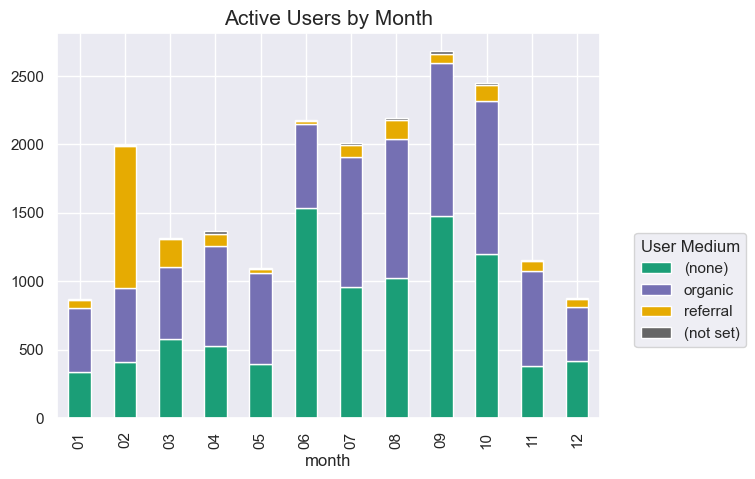

In [17]:
sns.set_theme()
monhtly_users_pivot.plot.bar(y = ['(none)', 'organic', 'referral', '(not set)'], stacked = True,
                             colormap = 'Dark2',
                             figsize=(7,5), title = 'Active Users by Month')
plt.legend(title = 'User Medium', bbox_to_anchor = (1.05, 0.5))
plt.title('Active Users by Month', fontsize = 15);

## GA4 Traffic Report

In [18]:
# Report dates
end_date = '2024-04-01' ## ("today" or "yyyy-mm-dd")
no_days = 365/4

In [19]:
def calc_start_date(end_date, no_days):
    if end_date == "today":
        start_date = date.today() - timedelta(days=no_days)
    else:
        start_date = date.fromisoformat(end_date) - timedelta(days=no_days)
        
    return start_date.strftime("%Y-%m-%d") 

def produce_report (end_date, no_days, property_id = property_id, client = client):
    daily_traffic_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="date"), 
                        Dimension(name="sessionMedium")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(dimension = {'dimension_name': 'date'}),
                        OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )
    
    page_users_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="pagePath")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(metric = {'metric_name': 'activeUsers'}, desc = True)],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )
    
    
    landing_page_users_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="landingPage")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(metric = {'metric_name': 'activeUsers'}, desc = True)],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )

    daily_traffic = format_report(daily_traffic_request).reset_index()
    active_users_pivot = pd.pivot_table(daily_traffic, 
                                     columns=['sessionMedium'], 
                                     index=['date'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)
    daily_traffic['date'] = pd.to_datetime(daily_traffic['date'], errors='coerce').dt.strftime('%Y-%m-%d')

    active_users_pivot.index = active_users_pivot.index.str.slice(start=4)
    
    # Produce pie and line charts
    
    fig, (axs1, axs2) = plt.subplots(1,2, figsize = (14, 4), gridspec_kw={'width_ratios': [1, 2]})
    # Asegúrate de que el índice y los datos sean de tipo adecuado
    pie_data = daily_traffic.groupby('sessionMedium', as_index=False)['activeUsers'].sum().sort_values(by='activeUsers', ascending=False)



    # Convertir el índice a string para asegurarse de que sea "hashable"
    pie_data.index = pie_data.index.astype(str) 
    # Restablecer el índice para que sea secuencial
    pie_data = pie_data.reset_index(drop=True)


    # Graficar pie chart
    # Crear gráfico de pastel con el índice corregido
    pie_data.plot.pie(
    ax=axs1,
    colormap='Dark2',
    y='activeUsers',  # Utilizamos el nombre de la columna directamente
    title='Active Users by Medium',
    legend=False,
    labels=pie_data['sessionMedium'],  # Usamos etiquetas para mostrar los medios de sesión
    startangle=0,
    autopct=lambda p: f'{p:.0f}%'
).set_ylabel('')


    
    active_users_pivot.plot.line(ax = axs2, 
                                 colormap = 'Dark2',
                                 y = pie_data.index, 
                                 title = 'Active Users by Day')


    axs2.legend(title = 'User Medium', bbox_to_anchor = (1.05, 0.6))

    plt.show();
    
    # Produce Top 10 pgaes output tables
    landing_table = format_report(landing_page_users_request)
    landing_table['activeUsers'] = landing_table['activeUsers'].astype('int') 
    page_users_table = format_report(page_users_request)
    page_users_table['activeUsers'] = page_users_table['activeUsers'].astype('int') 
    
    print('\nTop 10 Landing Pages')
    display(landing_table[0:10])
    print('\nTop 10 Visited Pages')
    display(page_users_table[0:10])

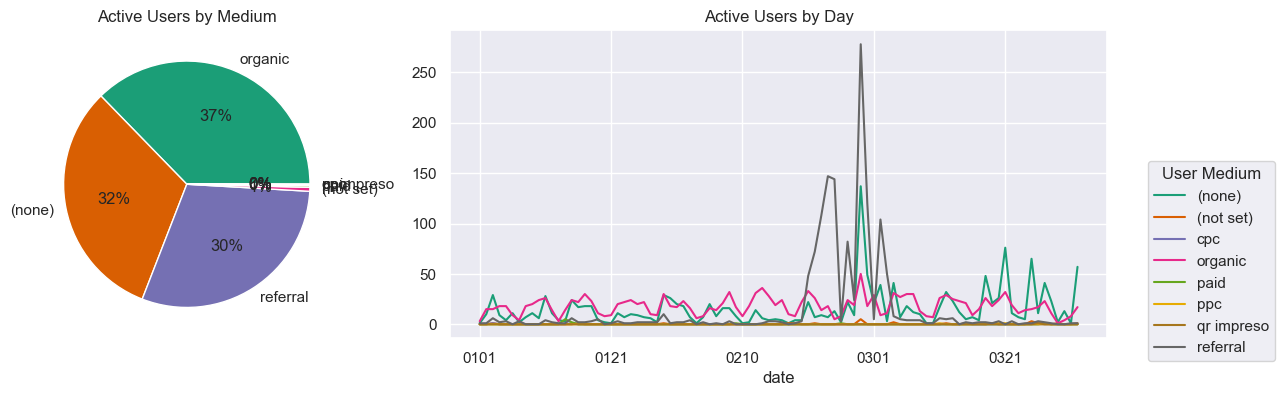


Top 10 Landing Pages


,activeUsers
landingPage,
/,1869
/2022/12/16/que-es-el-customer-insight-y-para-que-sirve,472
(not set),228
/2022/12/27/5-ejemplos-de-campanas-exitosa-usando-codigos-qr,173
/2022/12/27/digitar-digitalizacion-y-transformacion-digital,155
/datos,109
/conocimiento,108
/2022/12/19/como-las-diferencias-culturales-afectan-la-experiencia-del-cliente,99
/2022/12/19/como-se-regula-el-uso-de-cookies-en-chile,94



Top 10 Visited Pages


,activeUsers
pagePath,
/,1901
/2022/12/16/que-es-el-customer-insight-y-para-que-sirve/,472
/datos/,192
/2022/12/27/5-ejemplos-de-campanas-exitosa-usando-codigos-qr/,174
/2022/12/27/digitar-digitalizacion-y-transformacion-digital/,156
/crm/,144
/lealtad/,126
/conocimiento/,123
/2022/12/19/como-las-diferencias-culturales-afectan-la-experiencia-del-cliente/,100


In [20]:
produce_report(end_date, no_days)